# HO-MNIST Online Demo

In [1]:
# Main imports
import os
import sys
import numpy as np
import cv2
import torch
from torchvision import transforms
from matplotlib import pyplot as plt

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
    !pip install pyserial
    !git clone https://github.com/citiususc/ho-mnist.git
    !cd ho-mnist
    base_path = '/content/ho-mnist/'
    sys.path.insert(1, base_path)

else:
    base_path = './'

In [3]:
# Project imports
from homnist.visualization import DrawingCanvas
from homnist.learning import MinMaxScale, ConvertToBlackWhite
from homnist.network import HONet, HACCNet

In [4]:
# Global config
IMAGE_SIZE = [28, 28]  # MNIST input size
PENCIL_THICKNESS = 2.5
SIZE_MULTIPLIER = 20  # So things are not as small
TORCH_SEED = 1

In [5]:
# We define the model and a function to process images
torch.manual_seed(TORCH_SEED)
device = torch.device("cpu")

model = HONet()
state_dict = torch.load(os.path.join(base_path, 'models', 'mnist_quantized_converted.pth'))
model.load_state_dict(state_dict, strict=True)
model = model.to(device)
model.eval()

transform_test=transforms.Compose([
    transforms.ToTensor(),
    ConvertToBlackWhite(),
    transforms.Resize([16, 16], interpolation=transforms.InterpolationMode.NEAREST),
    MinMaxScale()
    ])

def process_image(image):
    # cv2.imwrite("my_drawing.png", image)
    with torch.no_grad():
        transformed_image = transform_test(image)
        transformed_image = transformed_image.unsqueeze(0)  # We add the "batch" dimension

        results_logits = model(transformed_image)
        results = model.softmax(results_logits)

        results = results[0]  # We remove the "batch" dimension
        results = results.detach().cpu().numpy()

    return results

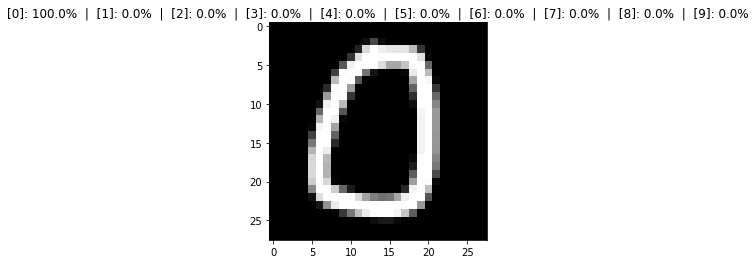

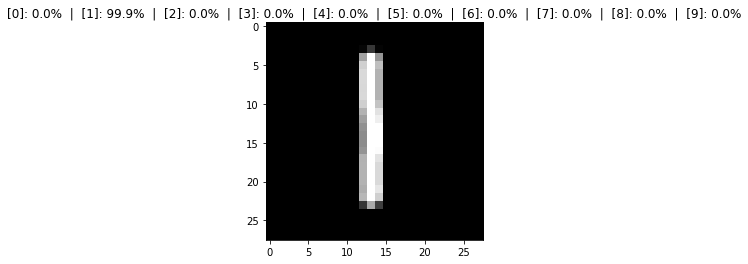

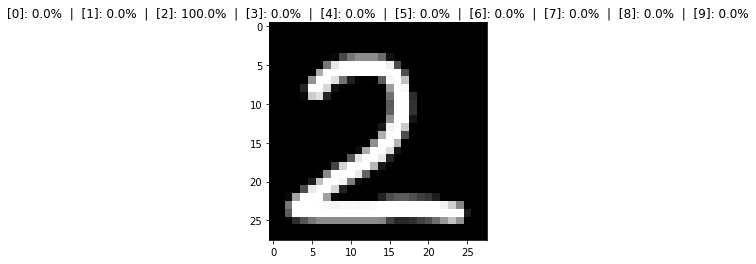

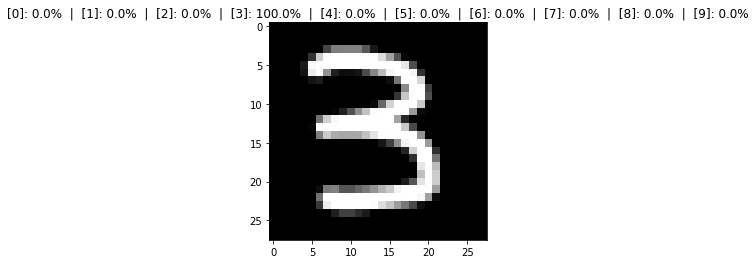

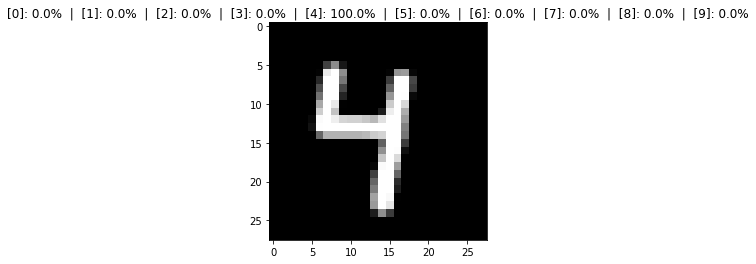

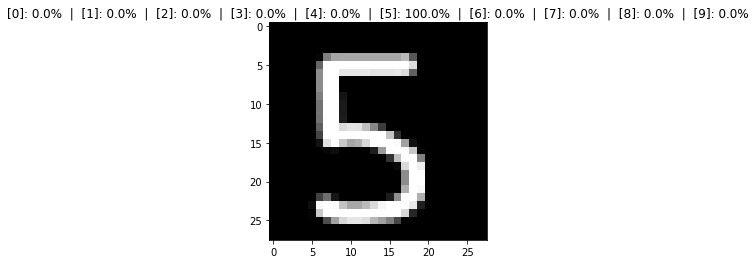

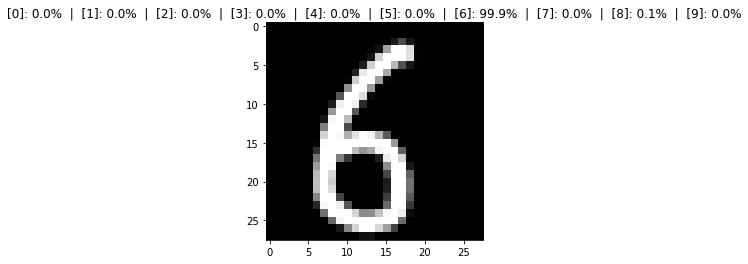

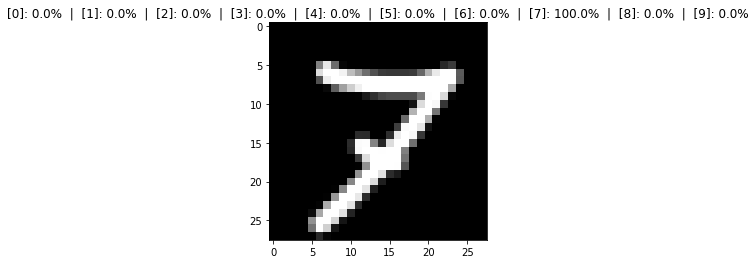

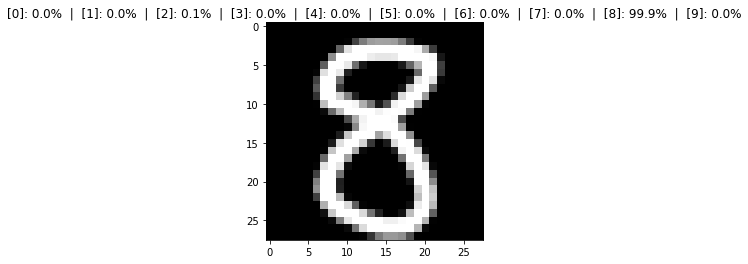

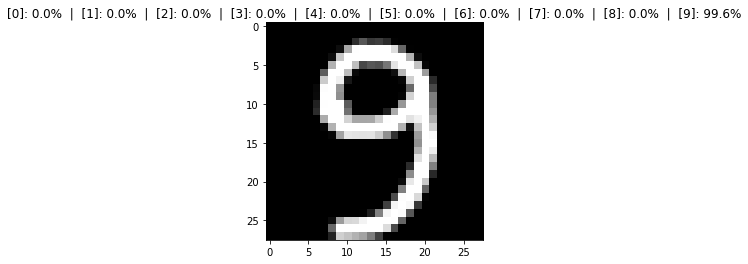

In [6]:
# We predict some sample digits
for number in range(10):
    # Load image
    image = cv2.imread(os.path.join(base_path, 'easy_numbers', '{}.png'.format(number)), cv2.IMREAD_GRAYSCALE)
    
    # Predict digit
    prediction = process_image(image)
    prediction_pretty = DrawingCanvas._mnist_results_text(prediction)
    
    # Display image
    plt.figure()
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.title(prediction_pretty)

-----

# Interactive drawing
**Only works in a local Jupyter Notebook**

In [7]:
canvas = DrawingCanvas(title='MNIST Draw', save_event=process_image, size=IMAGE_SIZE, pencil_thickness=PENCIL_THICKNESS, display_multiplier=SIZE_MULTIPLIER, save_while_drawing=True)
canvas.mainloop()